In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import os
import math

In [ ]:
df = pd.read_excel("./MachineLearning-Dataset-V1.xlsx")

In [ ]:
def scale_dataset(dataframe: pd.DataFrame, oversample: bool = False):
    # if target column is the last value
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [ ]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    return units, activation

In [ ]:
def plot_history(history, num_classes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history["loss"], label="loss")
    ax1.plot(history["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    if num_classes == 2:
        ax1.set_ylabel("Binary crossentropy")
    else:
        ax1.set_ylabel("Sparse categorical crossentropy")
    ax1.grid(True)

    ax2.plot(history["acc"], label="accuracy")
    ax2.plot(history["val_acc"], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)

    plt.show()

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation="relu"))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [107]:
def train_ngram_model(df,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        df: pandas dataframe containing train, test and validation data.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data. (train (60%), validation (20%) and test (20%) datasets)
    train, valid, test = np.split(df.sample(frac=1), [int(0.6 * len(df)), int(0.8 * len(df))])

    train, x_train, train_labels = scale_dataset(train, oversample=True)
    valid, x_val, val_labels = scale_dataset(valid, oversample=False)
    test, x_test, test_labels = scale_dataset(test, oversample=False)

    # Verify that validation labels are in the same range as training labels.
    num_classes = len(np.unique(df[df.columns[-1]].values)) + 1
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError("Unexpected label values found in the validation set:"
                         " {unexpected_labels}. Please make sure that the "
                         "labels in the validation set are in the same range "
                         "as training labels.".format(
                             unexpected_labels=unexpected_labels))

    # Create model instance.
    model = mlp_model(layers=layers,
                        units=units,
                        dropout_rate=dropout_rate,
                        input_shape=x_train.shape[1:],
                        num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = "binary_crossentropy"
    else:
        loss = "sparse_categorical_crossentropy"
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print("Validation accuracy: {acc}, loss: {loss}".format(
            acc=history["val_acc"][-1], loss=history["val_loss"][-1]))
    plot_history(history, num_classes)

    # Save model.
    model.save(os.path.join(os.environ["OUTPUT_PATH"], "Risk_factor_mlp_model.keras"))
    return history["val_acc"][-1], history["val_loss"][-1]

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


77/77 - 1s - loss: 1.0931 - acc: 0.5618 - val_loss: 0.8586 - val_acc: 0.5980 - 816ms/epoch - 11ms/step
Epoch 2/100
77/77 - 0s - loss: 0.6182 - acc: 0.7628 - val_loss: 0.6430 - val_acc: 0.7010 - 161ms/epoch - 2ms/step
Epoch 3/100
77/77 - 0s - loss: 0.5181 - acc: 0.7835 - val_loss: 0.5520 - val_acc: 0.7478 - 266ms/epoch - 3ms/step
Epoch 4/100
77/77 - 0s - loss: 0.4733 - acc: 0.7985 - val_loss: 0.4962 - val_acc: 0.7806 - 148ms/epoch - 2ms/step
Epoch 5/100
77/77 - 0s - loss: 0.4514 - acc: 0.8028 - val_loss: 0.4759 - val_acc: 0.7839 - 151ms/epoch - 2ms/step
Epoch 6/100
77/77 - 0s - loss: 0.4337 - acc: 0.8072 - val_loss: 0.4525 - val_acc: 0.7946 - 146ms/epoch - 2ms/step
Epoch 7/100
77/77 - 0s - loss: 0.4157 - acc: 0.8184 - val_loss: 0.4500 - val_acc: 0.7940 - 146ms/epoch - 2ms/step
Epoch 8/100
77/77 - 0s - loss: 0.4062 - acc: 0.8206 - val_loss: 0.4221 - val_acc: 0.8054 - 189ms/epoch - 2ms/step
Epoch 9/100
77/77 - 0s - loss: 0.4032 - acc: 0.8180 - val_loss: 0.4006 - val_acc: 0.8181 - 199ms/ep

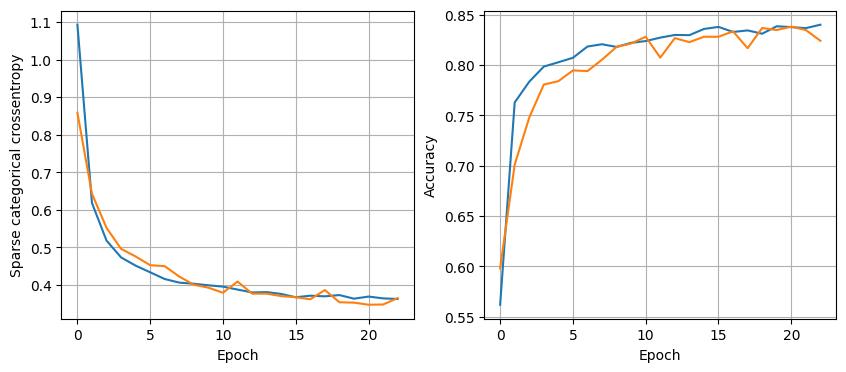

(0.8240802884101868, 0.36503472924232483)

In [108]:
train_ngram_model(df, epochs=100)